## Install package

Puedes instalar las dependencias listadas en el archivo `requirements.txt` utilizando el siguiente comando:

```bash
pip install -r requirements.txt

In [1]:
# pip install -r requirements.txt

## Data

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

import pyproj
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.pipeline import FeatureUnion

# import shapely.geometry
# from sklearn.model_selection import train_test_split


def clean_conducta(conducta):
    conducta = conducta.upper()
    conducta = conducta.replace(" ", "_")
    conducta = re.sub(
        r"[ÁÉÍÓÚ]",
        lambda m: m.group(0)
        .replace("Á", "A")
        .replace("É", "E")
        .replace("Í", "I")
        .replace("Ó", "O")
        .replace("Ú", "U"),
        conducta,
    )
    conducta = conducta.replace("Ñ", "N")
    return conducta


crimes_df = pd.read_csv("./base_crim16_08.csv")

# Select relevant features
features = [
    "fecha_hecho",
    "fecha",
    "year",
    "codigo_barrio",
    "latitud",
    "longitud",
    "conducta",
]
crimes_df = crimes_df[features]

# Eliminar espacios al principio y al final de los valores
crimes_df["fecha"] = crimes_df["fecha"].str.strip()
# Convertir a datetime
crimes_df["fecha"] = pd.to_datetime(crimes_df["fecha"], format="%d/%m/%Y")

crimes_df["fecha_hecho"] = pd.to_datetime(
    crimes_df["fecha_hecho"], format="%d/%m/%Y %H:%M"
)
crimes_df = crimes_df[
    (crimes_df["year"] >= 2008) & (crimes_df["year"] <= 2009)
]  # ? Select year 2008 and 2009

# ?---------------------------------------------------------------------- clean data
print("-> data shape ", crimes_df.shape)
total_duplicados = crimes_df.duplicated().sum()
print(f"-> Total de duplicados en el DataFrame: {total_duplicados}")
# Identificar registros duplicados
duplicados = crimes_df[crimes_df.duplicated()]
# Verificar si hay valores NaN en los registros duplicados
duplicados_con_nan = duplicados[duplicados.isnull().any(axis=1)]
print(f"-> Registros duplicados que contienen valores NaN: {duplicados_con_nan.shape}")

# Imprimir el total de valores NaN en cada columna
total_nan_por_columna = crimes_df.isnull().sum()
print("-> Missing values per column:")
print(total_nan_por_columna)

crimes_df = crimes_df.drop_duplicates()
crimes_df = crimes_df.dropna()
print("-> data shape ", crimes_df.shape)
# ?---------------------------------------------------------------------- clean data

print("\ncrimes dtypes: ", crimes_df.dtypes)

# ? DATE TIME STAMP FUNCTION
column_1 = crimes_df.iloc[:, 0]

db = pd.DataFrame(
    {
        "dayofyear": column_1.dt.dayofyear,
        "weekofyear": column_1.dt.isocalendar().week,
        "quarter": column_1.dt.quarter,
        "weekday": column_1.dt.weekday,
        "weekend": np.where(column_1.dt.weekday >= 4, 1, 0),
        # "Season": (
        #     column_1 - pd.DateOffset(months=1)
        # ).dt.quarter,
    }
)


crimes_df = crimes_df.drop("fecha_hecho", axis=1)  #! drop fecha_hecho
crimes_df = pd.concat([db, crimes_df], axis=1)
crimes_df["conducta"] = crimes_df["conducta"].apply(clean_conducta)
# data = pd.get_dummies(crimes_df.conducta)
# crimes_df = pd.concat([data, crimes_df], axis=1)
# crimes_df["codigo_barrio"] = crimes_df["codigo_barrio"].astype(str).str.replace("#", "")

crimes_df["codigo_barrio"] = pd.to_numeric(crimes_df["codigo_barrio"], errors="coerce")


crimes_df.describe()

-> data shape  (17707, 7)
-> Total de duplicados en el DataFrame: 8923
-> Registros duplicados que contienen valores NaN: (2472, 7)
-> Missing values per column:
fecha_hecho         0
fecha               0
year                0
codigo_barrio       0
latitud          4143
longitud         4143
conducta            0
dtype: int64
-> data shape  (7113, 7)

crimes dtypes:  fecha_hecho      datetime64[ns]
fecha            datetime64[ns]
year                      int64
codigo_barrio             int64
latitud                 float64
longitud                float64
conducta                 object
dtype: object


,dayofyear,weekofyear,quarter,weekday,weekend,fecha,year,codigo_barrio,latitud,longitud
count,7113.000000,7113.0,7113.000000,7113.000000,7113.000000,7113,7113.000000,7113.000000,7113.000000,7113.000000
mean,193.928160,28.238577,2.633769,2.994095,0.426402,2009-02-01 11:05:26.444538368,2008.558836,974.879938,6.255260,-75.575613
min,1.000000,1.0,1.000000,0.000000,0.000000,2008-01-01 00:00:00,2008.000000,101.000000,6.169881,-75.691148
25%,106.000000,16.0,2.000000,1.000000,0.000000,2008-07-30 00:00:00,2008.000000,602.000000,6.239632,-75.590200
50%,201.000000,29.0,3.000000,3.000000,0.000000,2009-02-10 00:00:00,2009.000000,1016.000000,6.252953,-75.571806
75%,286.000000,41.0,4.000000,5.000000,1.000000,2009-08-17 00:00:00,2009.000000,1211.000000,6.275024,-75.561147
max,366.000000,53.0,4.000000,6.000000,1.000000,2009-12-31 00:00:00,2009.000000,9003.000000,6.343814,-75.514766
std,105.649092,15.118914,1.110144,1.953471,0.494588,NaN,0.496561,647.807031,0.027002,0.020601


In [3]:
# imprimir los valores unicos de conducta
print("\n-> conducta unique values: ", crimes_df["conducta"].unique())


-> conducta unique values:  ['HURTO_DE_CARRO' 'HURTO_A_PERSONA' 'EXTORSION' 'HOMICIDIO'
 'HURTO_A_RESIDENCIA']


### SHP and intersections

### Barrios

In [5]:
# Set up transformers, EPSG:3857 is metric, same as EPSG:900913
to_proxy_transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:32618")
to_original_transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:32618")


# Perform spatial join by rounding coordinates for more accurate intersection
def round_coords(geom):
    if geom.type == "Polygon":
        return shapely.geometry.Polygon(
            [(round(x, 4), round(y, 4)) for x, y in geom.exterior.coords]
        )
    elif geom.type == "Point":
        return Point(round(geom.x, 5), round(geom.y, 5))
    else:
        return geom


# Definir la función de conversión de grados a metros
def convertir_lat_long_a_metros(lat, long):
    transformed = to_proxy_transformer.transform(lat, long)
    return transformed[0], transformed[1]


def create_gdf(df):
    gdf = df.copy()
    gdf["Coordinates"] = list(zip(round(gdf.longitud, 5), round(gdf.latitud, 5)))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(gdf, geometry="Coordinates", crs="epsg:32618")
    return gdf


crimes_gdf = create_gdf(crimes_df)
# print("len crimes_gdf ->",len(crimes_gdf))

# Convertir las coordenadas de latitud y longitud a metros y crear una nueva columna
crimes_gdf["Coordinates"] = crimes_gdf.apply(
    lambda row: Point(*convertir_lat_long_a_metros(row["latitud"], row["longitud"])),
    axis=1,
)


# ? eliminar todos los coordinates que tengan infinity
crimes_gdf = crimes_gdf[
    crimes_gdf["Coordinates"].apply(lambda x: not np.isinf(x.coords[0][0]))
]

# ? eliminar todos los registros que tengan latitud y longitud 0
crimes_gdf = crimes_gdf[
    crimes_gdf["Coordinates"].apply(
        lambda x: x.coords[0][0] != 0 and x.coords[0][1] != 0
    )
]

# ***************** Leer el archivo SHP y crear un objeto GeoDataFrame ***************
ruta_shp = "shp/map.shp"
gdf = gpd.read_file(ruta_shp)

# Filtrar por el código de comunas de Medellín (son 16 comunas en total)
gdf = gdf[gdf["LIMITECOMU"] < "17"]

# Reproyectar a coordenadas planas
gdf = gdf.to_crs(epsg=32618)

# imprimir algunas filas del archivo shp
# print(gdf.head(5))
# Realiza una unión basada en la relación "intersección"

# "Encoge" los polígonos en 0.5 unidades
buffer_size = -0.5
gdf["geometry"] = gdf["geometry"].buffer(buffer_size)

# Realizar el join espacial con la operación personalizada
crimes_gdf = gpd.sjoin(crimes_gdf, gdf[["area", "geometry"]], how="inner", op="within")

# eliminar columna de index_right
crimes_gdf = crimes_gdf.drop(columns=["index_right"])

# print("\n ---------------------------------------------------------- \n")
print(crimes_gdf.describe())


         dayofyear  weekofyear      quarter      weekday      weekend  \
count  7006.000000      7006.0  7006.000000  7006.000000  7006.000000   
mean    193.520554   28.178418     2.629460     2.986440     0.425064   
min       1.000000         1.0     1.000000     0.000000     0.000000   
25%     106.000000        16.0     2.000000     1.000000     0.000000   
50%     200.000000        29.0     3.000000     3.000000     0.000000   
75%     285.000000        41.0     4.000000     5.000000     1.000000   
max     366.000000        53.0     4.000000     6.000000     1.000000   
std     105.576804   15.108482     1.109564     1.953189     0.494388   

                               fecha         year  codigo_barrio      latitud  \
count                           7006  7006.000000    7006.000000  7006.000000   
mean   2009-02-01 01:03:06.011989760  2008.558807     935.156009     6.255421   
min              2008-01-01 00:00:00  2008.000000     101.000000     6.177433   
25%              2

c:\Users\mariacam.ardila\Documents\workspace-python\myven\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [6]:
# ?---------------------------------------------------------------------- clean data
print("-> data shape ", crimes_gdf.shape)
total_duplicados = crimes_gdf.duplicated().sum()
print(f"-> Total de duplicados en el DataFrame: {total_duplicados}")
# Identificar registros duplicados
duplicados = crimes_gdf[crimes_gdf.duplicated()]
# Verificar si hay valores NaN en los registros duplicados
duplicados_con_nan = duplicados[duplicados.isnull().any(axis=1)]
print(f"-> Registros duplicados que contienen valores NaN: {duplicados_con_nan.shape}")

# Imprimir el total de valores NaN en cada columna
total_nan_por_columna = crimes_gdf.isnull().sum()
print("-> Missing values per column:")
print(total_nan_por_columna)

crimes_gdf = crimes_gdf.drop_duplicates()
crimes_gdf = crimes_gdf.dropna()
print("-> data shape ", crimes_gdf.shape)
# ?---------------------------------------------------------------------- clean data


-> data shape  (7006, 13)
-> Total de duplicados en el DataFrame: 23
-> Registros duplicados que contienen valores NaN: (0, 13)
-> Missing values per column:
dayofyear        0
weekofyear       0
quarter          0
weekday          0
weekend          0
fecha            0
year             0
codigo_barrio    0
latitud          0
longitud         0
conducta         0
Coordinates      0
area             0
dtype: int64
-> data shape  (6983, 13)


In [7]:
# Convertir la columna de código de barrio a string
#crimes_gdf["codigo_barrio"] = crimes_gdf["codigo_barrio"].astype(str)

# Crear todas las combinaciones posibles de fechas, barrios y categorías de crimen
dates = pd.date_range(start=crimes_gdf["fecha"].min(), end=crimes_gdf["fecha"].max(), freq="D")
neighborhoods = crimes_gdf["codigo_barrio"].unique()
conducta_categories = ["HURTO_A_PERSONA", "HURTO_DE_CARRO", "HOMICIDIO", "HURTO_A_RESIDENCIA", "EXTORSION"]

index_combinations = pd.MultiIndex.from_product([neighborhoods, dates, conducta_categories],
                                                names=["codigo_barrio", "fecha", "conducta"])

# Crear un DataFrame con todas las combinaciones posibles
crime_count_per_day = pd.DataFrame(index=index_combinations).reset_index()

# Unir los datos de crímenes originales
crime_count_per_day = crime_count_per_day.merge(crimes_gdf, how="inner", on=["codigo_barrio", "fecha", "conducta"])

# Realizar el conteo y rellenar los valores faltantes con 0
crime_count_per_day = crime_count_per_day.groupby(["codigo_barrio", "fecha", "conducta"]).size().reset_index(name="crime_count")

# Crear todas las combinaciones posibles nuevamente
all_combinations = pd.MultiIndex.from_product([neighborhoods, dates, conducta_categories], names=["codigo_barrio", "fecha", "conducta"])

# Reindexar y llenar los valores faltantes con 0
crime_count_per_day = crime_count_per_day.set_index(["codigo_barrio", "fecha", "conducta"]).reindex(all_combinations, fill_value=0).reset_index()

# Mostrar las primeras filas del DataFrame resultante
print(crime_count_per_day.shape)
print(crime_count_per_day.head(50))


(902785, 4)
    codigo_barrio      fecha            conducta  crime_count
0             405 2008-01-01     HURTO_A_PERSONA            0
1             405 2008-01-01      HURTO_DE_CARRO            1
2             405 2008-01-01           HOMICIDIO            0
3             405 2008-01-01  HURTO_A_RESIDENCIA            0
4             405 2008-01-01           EXTORSION            0
5             405 2008-01-02     HURTO_A_PERSONA            0
6             405 2008-01-02      HURTO_DE_CARRO            0
7             405 2008-01-02           HOMICIDIO            0
8             405 2008-01-02  HURTO_A_RESIDENCIA            0
9             405 2008-01-02           EXTORSION            0
10            405 2008-01-03     HURTO_A_PERSONA            0
11            405 2008-01-03      HURTO_DE_CARRO            0
12            405 2008-01-03           HOMICIDIO            0
13            405 2008-01-03  HURTO_A_RESIDENCIA            0
14            405 2008-01-03           EXTORSION          

In [8]:
# #original crime_count
# #convertir la columna de codigo de barrio a string
# crimes_gdf["codigo_barrio"] = crimes_gdf["codigo_barrio"].astype(str)

# # Agrupar los datos por 'codigo_barrio', 'fecha' y 'conducta' y contar las ocurrencias
# crime_count_per_day = crimes_gdf.groupby(["codigo_barrio", "fecha","conducta"]).size()

# # Desapilar y rellenar los datos faltantes con 0
# crime_count_per_day = (
#     crime_count_per_day.unstack(["codigo_barrio", "conducta"])
#     .asfreq("D")
#     .fillna(0)
#     .stack(["codigo_barrio", "conducta"])
# )

# crime_count_per_day = pd.DataFrame(crime_count_per_day).rename(
#     columns={0: "crime_count"}
# )

# crime_count_per_day.head(50)
# # crime_count_per_day.to_csv("crimecount.csv")
# #crimes_gdf.to_csv("crime_gdf.csv")

In [9]:
# Obtén los valores únicos de la columna "codigo_barrio"
neighborhoods = crimes_gdf["codigo_barrio"].unique()

# Crea un nuevo DataFrame con los valores únicos de "codigo_barrio" y su respectiva "area"
unique_neighborhoods_df = pd.DataFrame({'codigo_barrio': neighborhoods})
print(unique_neighborhoods_df.shape)

# Puedes utilizar el método merge para agregar la columna "area" al nuevo DataFrame
unique_neighborhoods_df = unique_neighborhoods_df.merge(crimes_gdf[['codigo_barrio', 'area']], on='codigo_barrio', how='inner')

# ?---------------------------------------------------------------------- clean data
print("-> data shape ", unique_neighborhoods_df.shape)
total_duplicados = unique_neighborhoods_df.duplicated().sum()
print(f"-> Total de duplicados en el DataFrame: {total_duplicados}")
# Identificar registros duplicados
duplicados = unique_neighborhoods_df[unique_neighborhoods_df.duplicated()]
# Verificar si hay valores NaN en los registros duplicados
duplicados_con_nan = duplicados[duplicados.isnull().any(axis=1)]
print(f"-> Registros duplicados que contienen valores NaN: {duplicados_con_nan.shape}")

# Imprimir el total de valores NaN en cada columna
total_nan_por_columna = unique_neighborhoods_df.isnull().sum()
print("-> Missing values per column:")
print(total_nan_por_columna)

unique_neighborhoods_df = unique_neighborhoods_df.drop_duplicates()
unique_neighborhoods_df = unique_neighborhoods_df.dropna()
print("-> data shape ", unique_neighborhoods_df.shape)
# ?---------------------------------------------------------------------- clean data


# Ahora, unique_neighborhoods_df contiene los valores únicos de "codigo_barrio" y su respectiva "area"
print(unique_neighborhoods_df.describe())


(247, 1)
-> data shape  (6983, 2)
-> Total de duplicados en el DataFrame: 6736
-> Registros duplicados que contienen valores NaN: (0, 2)
-> Missing values per column:
codigo_barrio    0
area             0
dtype: int64
-> data shape  (247, 2)
       codigo_barrio          area
count     247.000000  2.470000e+02
mean      903.000000  3.770224e+05
std       447.119425  2.093625e+05
min       101.000000  5.800020e+04
25%       513.500000  2.336933e+05
50%       908.000000  3.408416e+05
75%      1307.500000  4.554745e+05
max      1621.000000  1.401969e+06


In [10]:
crime_count_per_day = crime_count_per_day.merge(
    unique_neighborhoods_df,
    on=["codigo_barrio"],
    how="left",
)
print(crime_count_per_day.shape)

(902785, 5)


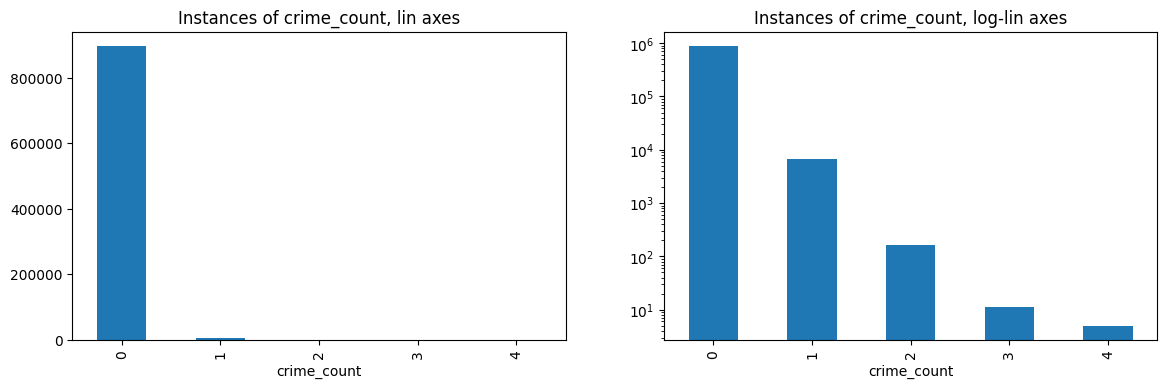

In [11]:
#Instances of crime_count per date, neighborhood, and crime category
cc = crime_count_per_day.groupby('crime_count').size()
fig, axes = plt.subplots(1, 2, figsize=(14, 4));
cc.plot.bar(logy=False, ax=axes[0], title='Instances of crime_count, lin axes');
cc.plot.bar(logy=True, ax=axes[1], title='Instances of crime_count, log-lin axes');

In [12]:
crime_count_per_day.isna().sum()

codigo_barrio    0
fecha            0
conducta         0
crime_count      0
area             0
dtype: int64

### Load and Merge characteristics

In [13]:
# crime_count_per_day = crime_count_per_day.merge(
#     crimes_gdf[
#         [
#             "codigo_barrio",
#             "weekday",
#             "weekend",
#             "dayofyear",
#             "weekofyear",
#             "quarter",
#         ]
#     ],
#     on="codigo_barrio",
#     how="left",
# )
# crime_count_per_day.sample(5)
# # crime_count_per_day.to_csv('crimecount.csv')

In [14]:
characteristics = pd.read_excel("./characteristics.xlsx")
#characteristics=characteristics[['CODIGO','year','edad','inseg','gender','atraco','seg', 'casado','pensionado', 'estra_12', 'ofi_hogar', 'acu_si','ipm','childhood','youth','adult','def_cuantitativo','def_cualitativo']]
characteristics=characteristics[['CODIGO','year','edad','inseg','atraco','seg','ipm','youth','adult','def_cuantitativo','def_cualitativo']]

# eliminaar registros que tengan CODIGO null nan o con un caracter '.'
characteristics = characteristics[characteristics["CODIGO"].notna()]
characteristics = characteristics[characteristics["CODIGO"] != "."]

# convertir a entero el codigo
characteristics["CODIGO"] = characteristics["CODIGO"].astype(int)

# renombrar columna de characteristics "CODIGO" a "codigo_barrio"
characteristics = characteristics.rename(columns={"CODIGO": "codigo_barrio"})

# Se realiza el merge de crime_count_per_day characteristics left de crime_count_per_day
crime_count_per_day['year'] = pd.to_datetime(crime_count_per_day['fecha']).dt.year
crime_count_per_day = crime_count_per_day.merge(characteristics, how='left', on=['codigo_barrio', 'year'])

print("-> Missing values: \n")
print(crime_count_per_day.isnull().sum())
# drop missing values
print("-> Dropping missing values: \n")
crime_count_per_day = crime_count_per_day.dropna()
# elimianr los datos repetidos
print("-> Eliminar los datos repetidos \n")
crime_count_per_day = crime_count_per_day.drop_duplicates()

crime_count_per_day.sample(10)

-> Missing values: 

codigo_barrio           0
fecha                   0
conducta                0
crime_count             0
area                    0
year                    0
edad                38380
inseg               38380
atraco              38380
seg                 38380
ipm                 38380
youth               38380
adult               38380
def_cuantitativo    38380
def_cualitativo     38380
dtype: int64
-> Dropping missing values: 

-> Eliminar los datos repetidos 



,codigo_barrio,fecha,conducta,crime_count,area,year,edad,inseg,atraco,seg,ipm,youth,adult,def_cuantitativo,def_cualitativo
794240,1302,2008-08-09,HURTO_A_PERSONA,0,121788.497798,2008,26.921568,0.421569,0.107843,0.529412,0.666667,0.323529,0.362745,0.294118,0.862745
366576,1008,2008-08-03,HURTO_DE_CARRO,0,329852.402136,2008,37.599998,0.000000,0.000000,1.000000,0.866667,0.266667,0.600000,0.000000,1.000000
576988,1311,2009-09-22,HURTO_A_RESIDENCIA,0,367610.380527,2009,38.027779,0.166667,0.000000,0.422222,0.972222,0.261111,0.583333,0.050000,0.961111
498921,1014,2009-01-03,HURTO_DE_CARRO,0,322561.304635,2009,33.798122,0.049296,0.018779,0.739437,0.950704,0.262911,0.507042,0.042253,0.915493
475195,807,2008-01-10,HURTO_A_PERSONA,0,466703.667599,2008,31.567839,0.132328,0.056951,0.773869,0.695142,0.279732,0.472362,0.043551,0.864322
38432,514,2009-01-11,HOMICIDIO,0,353910.883561,2009,34.116070,0.125000,0.000000,0.716518,0.973214,0.292411,0.500000,0.089286,0.917411
170805,1202,2009-06-19,HURTO_A_PERSONA,0,312879.465364,2009,44.811520,0.246073,0.099476,0.649215,0.968586,0.235602,0.664922,0.000000,1.000000
302996,303,2009-10-19,HURTO_DE_CARRO,0,388349.919954,2009,33.733234,0.307005,0.038748,0.609538,0.959762,0.272727,0.503726,0.159464,0.904620
527772,1401,2008-10-17,HOMICIDIO,0,401209.018724,2008,43.538460,0.000000,0.000000,0.538462,0.846154,0.307692,0.692308,0.000000,1.000000
307420,410,2008-03-21,HURTO_A_PERSONA,0,371742.084762,2008,38.039684,0.029762,0.017857,0.960317,0.708333,0.263889,0.561508,0.079365,0.823413


In [15]:
# Description of our new dataset 
crime_count_per_day.describe()

,codigo_barrio,fecha,crime_count,area,year,edad,inseg,atraco,seg,ipm,youth,adult,def_cuantitativo,def_cualitativo
count,864405.000000,864405,864405.000000,8.644050e+05,864405.000000,864405.000000,864405.000000,864405.000000,864405.000000,864405.000000,864405.000000,864405.000000,864405.000000,864405.000000
mean,902.002181,2008-12-31 09:16:21.852256768,0.007837,3.792421e+05,2008.500373,34.879745,0.162480,0.050039,0.719790,0.847040,0.264594,0.520010,0.099872,0.900867
min,101.000000,2008-01-01 00:00:00,0.000000,5.800020e+04,2008.000000,22.110344,0.000000,0.000000,0.000000,0.435897,0.000000,0.254717,0.000000,0.325581
25%,513.000000,2008-07-02 00:00:00,0.000000,2.359682e+05,2008.000000,30.542124,0.067385,0.015228,0.634011,0.732394,0.240695,0.442831,0.007194,0.846154
50%,907.000000,2009-01-01 00:00:00,0.000000,3.478878e+05,2009.000000,34.275555,0.120000,0.039242,0.747253,0.919283,0.266082,0.520129,0.050967,0.940767
75%,1308.000000,2009-07-02 00:00:00,0.000000,4.667037e+05,2009.000000,38.725739,0.216216,0.068627,0.849057,0.958084,0.287037,0.597561,0.145714,0.996633
max,1621.000000,2009-12-31 00:00:00,4.000000,1.401969e+06,2009.000000,53.688744,0.859485,0.443038,1.000000,1.000000,0.599010,1.000000,0.971311,1.000000
std,448.590650,NaN,0.091043,2.093752e+05,0.500000,5.750466,0.143794,0.052493,0.176351,0.123896,0.046031,0.106812,0.126809,0.120505


In [16]:
crime_count_per_day.dtypes

codigo_barrio                int64
fecha               datetime64[ns]
conducta                    object
crime_count                  int64
area                       float64
year                         int32
edad                       float64
inseg                      float64
atraco                     float64
seg                        float64
ipm                        float64
youth                      float64
adult                      float64
def_cuantitativo           float64
def_cualitativo            float64
dtype: object

In [17]:
# save crime count per day into csv file
# crime_count_per_day.to_csv("crime_count_per_day.csv", index=False)

In [18]:
crime_count_per_day.isna().sum()

codigo_barrio       0
fecha               0
conducta            0
crime_count         0
area                0
year                0
edad                0
inseg               0
atraco              0
seg                 0
ipm                 0
youth               0
adult               0
def_cuantitativo    0
def_cualitativo     0
dtype: int64

### Alpha

In [19]:
alpha = 7
aslice = pd.DataFrame()
for cond in crime_count_per_day["conducta"].unique():
    for cod in crime_count_per_day["codigo_barrio"].unique():
        # Slice data per cod-conducta
        dslice = crime_count_per_day.query(
            "conducta == @cond and codigo_barrio == @cod"
        )[["codigo_barrio", "conducta", "fecha", "crime_count"]]
        # Rolling sum, don't allow starting nan:s
        rollslice = (
            dslice[["fecha", "crime_count"]]
            .rolling(alpha, center=False, on="fecha")
            .sum()
            .fillna(method="bfill")
        )
        rollslice = rollslice.rename(columns={"crime_count": "Rolling_sum"})
        # merge
        dslice = dslice.merge(rollslice, on="fecha", how="left").drop(
            "crime_count", axis=1
        )
        aslice = pd.concat([aslice, dslice], ignore_index=True)
# merge with main table
crime_count_per_day = crime_count_per_day.merge(
    aslice, on=["fecha", "codigo_barrio", "conducta"], how="left"
)
colnames = ["alpha_crime_dens_area_" + str(alpha)]

# normalize
crime_count_per_day[colnames[0]] = (
    crime_count_per_day["Rolling_sum"] / crime_count_per_day["area"]
)
crime_count_per_day = crime_count_per_day.drop("Rolling_sum", axis=1)

In [20]:
alpha = 30
aslice = pd.DataFrame()

for cond in crime_count_per_day["conducta"].unique():
    for cod in crime_count_per_day["codigo_barrio"].unique():
        dslice = crime_count_per_day.query(
            "conducta == @cond and codigo_barrio == @cod"
        )[["codigo_barrio", "conducta", "fecha", "crime_count"]]
        rollslice = (
            dslice[["fecha", "crime_count"]]
            .rolling(alpha, center=False, on="fecha")
            .sum()
            .fillna(method="bfill")
        )
        rollslice = rollslice.rename(columns={"crime_count": "Rolling_sum"})
        dslice = dslice.merge(rollslice, on="fecha", how="left").drop(
            "crime_count", axis=1
        )
        aslice = pd.concat([aslice, dslice], ignore_index=True)

crime_count_per_day = crime_count_per_day.merge(
    aslice, on=["fecha", "codigo_barrio", "conducta"], how="left"
)

colnames = ["alpha_crime_dens_area_" + str(alpha)]
crime_count_per_day[colnames[0]] = (
    crime_count_per_day["Rolling_sum"] / crime_count_per_day["area"]
)
crime_count_per_day = crime_count_per_day.drop("Rolling_sum", axis=1)

### Correlation features

In [21]:
# import seaborn as sns
# sns.set()
# crime_count_per_day_cd = crime_count_per_day.drop(['conducta','crime_count'], axis=1)

# #Adding dummy feature to get full cmap scale (really complicated to solve in sns/matplotlib)
# crime_count_per_day_cd['dummy_feature'] = -crime_count_per_day_cd['pensionado']
# corr = crime_count_per_day_cd.corr()

# # Create a heatmap
# fig, ax = plt.subplots(figsize=(10, 8))
# sns.heatmap(corr,
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values,
#             cmap='RdBu_r',
#             ax=ax)

# # Remove the dummy feature
# crime_count_per_day_cd = crime_count_per_day_cd.drop('dummy_feature', axis=1)

# plt.show()

### Train-dev-test split

In [22]:
# Sort columns on name for easier handling of predictions downstream
crime_data_grd = crime_count_per_day.reindex(
    sorted(crime_count_per_day.columns), axis=1
)


X_train = crime_data_grd[crime_data_grd['year'] <= 2008] 
#crime_data_grd.query('fecha < "2018-01-01"')
X_test = crime_data_grd[crime_data_grd['year'] == 2009]  
#crime_data_grd.query('fecha >= "2018-01-01"')

#labels for classifier
y_train_clf = X_train['crime_count'].clip(upper=1).astype(int)
y_test_clf = X_test['crime_count'].clip(upper=1).astype(int)

#labels for regression
y_train_reg = X_train['crime_count']
y_test_reg = X_test['crime_count']

#Clean
X_train = X_train.drop(['crime_count','fecha','year','codigo_barrio'],axis=1)
X_test = X_test.drop(['crime_count','fecha','year','codigo_barrio'],axis=1)

#Check split ratios
time_split = int(len(X_train)/(len(crime_data_grd))*100)
event_split = int(y_train_clf.sum()/(y_train_clf.sum()+y_test_clf.sum())*100)
print("Train/test split in time: {}/{}".format(time_split, 100-time_split))
print("Train/test split in events: {}/{}".format(event_split, 100-event_split))

Train/test split in time: 49/51
Train/test split in events: 44/56


In [23]:
X_train.sample(10)

,adult,alpha_crime_dens_area_30,alpha_crime_dens_area_7,area,atraco,conducta,def_cualitativo,def_cuantitativo,edad,inseg,ipm,seg,youth
115247,0.415094,0.000000,0.000000,366048.700330,0.127359,HOMICIDIO,0.957547,0.000000,29.735849,0.160377,0.551887,0.707547,0.367924
467614,0.556270,0.000000,0.000000,381968.472210,0.045016,EXTORSION,0.954984,0.045016,36.723473,0.083601,0.691318,0.771704,0.260450
666923,0.315175,0.000000,0.000000,264437.104492,0.159533,HURTO_A_RESIDENCIA,0.688716,0.482490,26.680933,0.031128,0.789883,0.968872,0.361868
449348,0.472803,0.000000,0.000000,289712.557192,0.012552,HURTO_A_RESIDENCIA,0.765690,0.200837,32.548119,0.058577,0.799163,0.322176,0.297071
27092,0.638889,0.000013,0.000004,227269.684374,0.000000,HOMICIDIO,1.000000,0.061111,40.466667,0.077778,0.850000,0.905555,0.250000
584624,0.515556,0.000000,0.000000,446449.769945,0.013333,EXTORSION,0.973333,0.102222,34.275555,0.293333,0.640000,0.684444,0.240000
568811,0.608466,0.000000,0.000000,507647.420199,0.050264,HURTO_DE_CARRO,0.941799,0.000000,38.031746,0.121693,0.719577,0.701058,0.238095
286495,0.619718,0.000000,0.000000,248088.656801,0.035211,HURTO_A_PERSONA,0.985915,0.000000,36.985916,0.105634,0.732394,0.795775,0.225352
172870,0.668224,0.000003,0.000003,363497.064123,0.056075,HURTO_A_PERSONA,1.000000,0.046729,44.448597,0.126168,0.808411,0.845794,0.252336
175684,0.568365,0.000000,0.000000,554020.561780,0.018767,EXTORSION,0.970509,0.000000,38.356567,0.152815,0.777480,0.697051,0.297587


### Model preprocessing pipeline

In [24]:
#source: https://github.com/ageron/handson-ml
class LabelBinarizerPipelineFriendly(LabelBinarizer):
    """Binarize Label in a One vs all fashion. This utility class would
    enable people to use this with categorical variables in pipelines.
    Refer to LabelBinarizer for detailed info.
    """

    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)

    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)


In [27]:
#Numerical features. Using a StandardScaler to be insensitive to any outliers.
num_attributes = X_train.select_dtypes(exclude=[object]).columns
num_mapper = DataFrameMapper(gen_features(
    columns=[[f] for f in num_attributes],
    classes=[
            StandardScaler
            ]
))

#Categorical features. One-hot encode (binarize) the features.
cat_attributes = X_train.select_dtypes(include=[object]).columns
cat_mapper = DataFrameMapper(gen_features(
    columns=[[f] for f in cat_attributes],
    classes=[LabelBinarizerPipelineFriendly]
))

#Union
full_pipeline = FeatureUnion(transformer_list=[
    ('num_mapper', num_mapper),
    ('cat_mapper', cat_mapper),
])

X_train_prep = full_pipeline.fit_transform(X_train)
X_test_prep = full_pipeline.transform(X_test)
print(num_attributes)
print(cat_attributes)
print(np.shape(X_train_prep))
print(X_train_prep[1])


Index(['adult', 'alpha_crime_dens_area_30', 'alpha_crime_dens_area_7', 'area',
       'atraco', 'def_cualitativo', 'def_cuantitativo', 'edad', 'inseg', 'ipm',
       'seg', 'youth'],
      dtype='object')
Index(['conducta'], dtype='object')
(431880, 17)
[-1.04425483  1.95565061  2.66795297  0.49826194 -0.58743844 -0.26640247
  0.2148888  -1.07874078 -0.03039238 -0.56634143  0.50165352  0.28132174
  0.          0.          0.          0.          1.        ]


## Train model

In [28]:
from scipy.stats import randint as sp_randint
from sklearn.metrics import precision_recall_curve, confusion_matrix, make_scorer, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV

#Select best models: best balanced classes and unbalanced classes. 
#Could use refit=True in search above if you want to include search and run code top-to-bottom.
#rfc1 = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced', max_depth=8, n_estimators=113, min_samples_leaf=10)
rfc1 = RandomForestClassifier()
rfc1.fit(X_train_prep, y_train_clf)
#rfc2 = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced', max_depth=69, n_estimators=64, min_samples_leaf=132)
#rfc2.fit(X_train_prep, y_train_clf)

RandomForestClassifier()

### Model evaluation

In [29]:
def obtain_and_plot_evaluation_figures(model, X, y, method, datatype, cv=3, verbose=100, title_prefix=None):
    if datatype == 'train':
        y_pred = cross_val_predict(model, X, y, cv=cv, method=method, verbose=verbose)
    elif datatype == 'test':
        y_pred = model.predict_proba(X)
    precisions, recalls, thresholds = precision_recall_curve(y, y_pred[:,1])
        #y_pred = model.predict_proba(X)
        
    # if datatype == 'train':
    #     precisions, recalls, thresholds = precision_recall_curve(y, y_pred)
    # else:
    #     precisions, recalls, thresholds = precision_recall_curve(y, y_pred)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5));
    ax1.plot(thresholds, precisions[:-1], "b--", label="Precision");
    ax1.plot(thresholds, recalls[:-1], "g-", label="Recall");
    ax1.set(xlabel="Thresholds");
    ax1.set_ylim([0,1]);
    ax1.legend();
    ax1.set_title(title_prefix + 'Precision & recall at thresholds');

    ax2.plot(precisions, recalls, label=None);
    ax2.set_ylim([0,1]);
    ax2.set_xlim([0,1]);
    ax2.set(xlabel="Precision", ylabel="Recall");
    ax2.set_title(title_prefix + 'Precision-recall curve');
    print(np.shape(y_pred))

In [ ]:
# pip install joblib


In [ ]:
import joblib
# Guardar el modelo en un archivo con compresión
model_filename = 'random_forest_model_compre_27_08.joblib'
joblib.dump(rfc1, model_filename, compress=5)  # El valor 3 controla el nivel de compresión
# Cargar el modelo desde el archivo
loaded_model = joblib.load(model_filename)

In [ ]:
print(y_train_clf.head())

print(y_train_clf.shape)

(431880, 2)


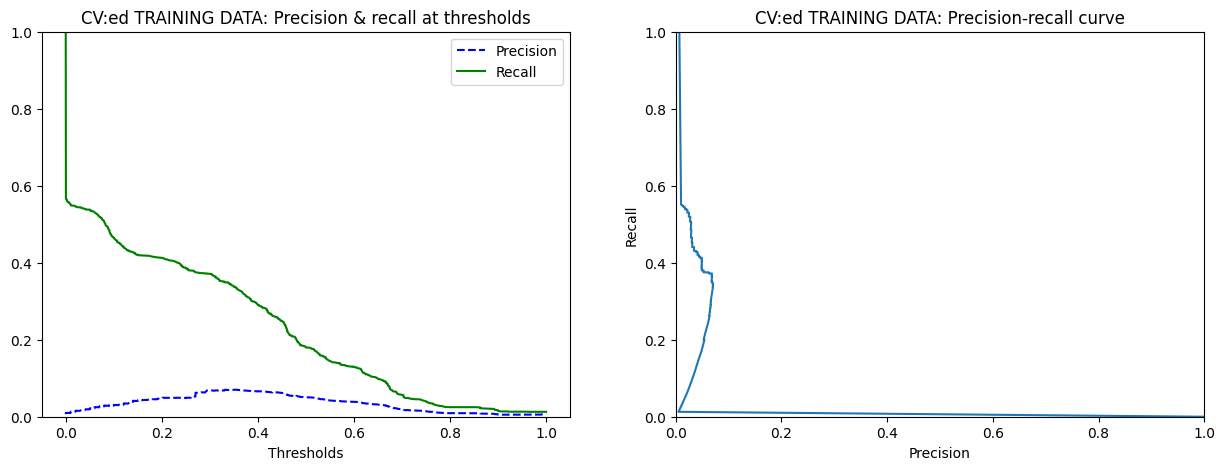

In [30]:
obtain_and_plot_evaluation_figures(model=rfc1, X=X_train_prep, y=y_train_clf, datatype='train', method='predict_proba', cv=3, verbose=0, title_prefix='CV:ed TRAINING DATA: ')

(432525, 2)


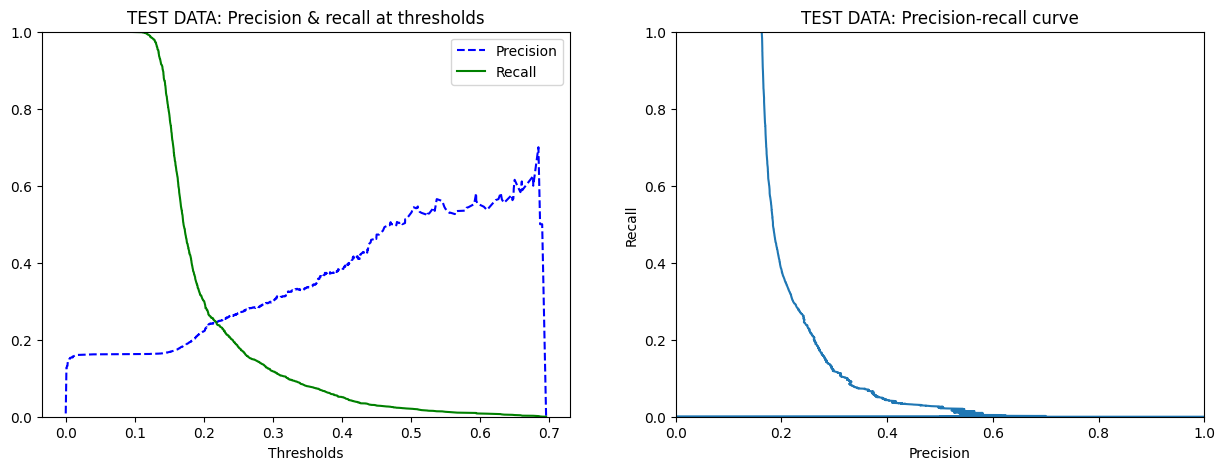

In [31]:
obtain_and_plot_evaluation_figures(model=rfc1, X=X_test_prep, y=y_test_clf, datatype='test', method='predict_proba', verbose=0, title_prefix='TEST DATA: ')

In [32]:
print('CV:ed TRAINING DATA: \n' + classification_report(y_train_clf, cross_val_predict(rfc1, X_train_prep, y_train_clf, cv=3)))
print('TEST DATA: \n' + classification_report(y_test_clf, rfc1.predict(X_test_prep)))

CV:ed TRAINING DATA: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    428977
           1       0.06      0.22      0.09      2903

    accuracy                           0.97    431880
   macro avg       0.53      0.60      0.54    431880
weighted avg       0.99      0.97      0.98    431880

TEST DATA: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    428850
           1       0.53      0.02      0.04      3675

    accuracy                           0.99    432525
   macro avg       0.76      0.51      0.52    432525
weighted avg       0.99      0.99      0.99    432525



### Duplicated train/test data

In [33]:
#All duplicates and also without alpha-days crime density columns
#Training data
dupl = X_train.duplicated().sum()
dupl_wo_alpha = X_train.drop([col for col in X_train.columns if 'alpha' in col], axis=1).duplicated().sum()
print(dupl/len(X_train)*100)
print(dupl_wo_alpha/len(X_train)*100)

99.11665277391867
99.72677595628416


In [34]:
#Test data
dupl = X_test.duplicated().sum()
dupl_wo_alpha = X_test.drop([col for col in X_test.columns if 'alpha' in col], axis=1).duplicated().sum()
print(dupl/len(X_test)*100)
print(dupl_wo_alpha/len(X_test)*100)

98.95959771111497
99.72602739726028


### Feature importance

In [35]:
#Using RFC attribute feature_importance_, which is based on position in decision trees (higher = more important, since it's greedy)
feature_names = list(num_mapper.transformed_names_) + list(cat_mapper.transformed_names_)
sorted(zip(rfc1.feature_importances_, feature_names), reverse=True)

[(0.5796809313204679, 'alpha_crime_dens_area_7'),
 (0.222887384604562, 'alpha_crime_dens_area_30'),
 (0.018434091548187828, 'area'),
 (0.016926914756948144, 'conducta_HURTO_A_PERSONA'),
 (0.016017182752305365, 'adult'),
 (0.015302196632471758, 'inseg'),
 (0.015114273462449148, 'youth'),
 (0.014289120125016371, 'conducta_HURTO_DE_CARRO'),
 (0.013835025713674788, 'seg'),
 (0.013783567181352565, 'conducta_HOMICIDIO'),
 (0.01319867472009754, 'atraco'),
 (0.012741057710582745, 'edad'),
 (0.012723663745191544, 'ipm'),
 (0.011875103580064108, 'def_cuantitativo'),
 (0.0106684058432065, 'def_cualitativo'),
 (0.009673928485990923, 'conducta_HURTO_A_RESIDENCIA'),
 (0.0028484778174308915, 'conducta_EXTORSION')]

### Predictions 

In [36]:
def retrieve_imputed_assembled_feature_matrix(CDG_lookup, pdate):    
    # nh_features = CDG_lookup.drop_duplicates('codigo_barrio')[['area', 'Pop_cnt', 'median_age', 'median_income','Male_pop_ratio', 'Age18Plus_ratio']]
    nh_features = CDG_lookup.drop_duplicates("codigo_barrio")[
        [
            "area",
            "edad",
            "inseg",
            "adult",
            "youth",
            "ipm",
            "seg",
            "atraco",
            "def_cualitativo",
            "def_cuantitativo",
        ]
    ]

    #? alpha
    alpha_cols = [col for col in CDG_lookup if "alpha" in col]
    # alpha_features = CDG_lookup.drop_duplicates(['fecha','codigo_barrio','conducta']).groupby(['codigo_barrio','conducta']).median()[alpha_cols]
    alpha_features = CDG_lookup.groupby(["codigo_barrio", "conducta"])[
        alpha_cols
    ].median()
    alpha_features = alpha_features.reset_index().drop("codigo_barrio", axis=1)

    #? date
    date_features = {}
    pdate = pd.to_datetime(pdate, format="%Y-%m-%d")
    date_features["weekday"] = pdate.weekday()
    # date_features['weekend'] = np.asscalar(np.where(date_features['weekday_num'] >= 4, 1, 0))
    date_features["weekend"] = np.where(date_features["weekday"] >= 4, 1, 0)
    date_features = pd.DataFrame(data=date_features, index=[0])

    #? Crime cats
    crime_cats = pd.DataFrame(crime_data_grd.drop_duplicates("conducta")["conducta"])

    #? Stitch together
    X_pred = nh_features.reset_index(drop=True).copy()
    # X_pred = X_pred.merge(nh_year_features, left_index=True, right_index=True)
    X_pred = X_pred.merge(date_features, left_index=True, right_index=True)
    X_pred = (
        X_pred.merge(crime_cats, how="right", left_index=True, right_index=True)
        .fillna(method="ffill")
        .fillna(method="bfill")
    )
    X_pred = X_pred.merge(alpha_features, on="conducta")
    X_pred = X_pred.reindex(sorted(X_pred.columns), axis=1)

    return X_pred

In [37]:
def get_crime_probas(codigo_barrio, pdate, model=rfc1):
    # make sure we have a valid date
    try:
        pd.to_datetime(pdate, format="%Y-%m-%d")
    except:
        raise ValueError("pd.to_datetime() failed, only supports valid dates.")
    drop_columns = [
        "crime_count",
        "fecha",
        "codigo_barrio",
        "year",
    ]  #"edad", "geometry"
    # Slice main table
    # CDG_lookup = crime_data_grd.query('fecha == @pdate and codigo_barrio == @codigo_barrio')
    CDG_lookup = crime_data_grd.query(
        "fecha == @pdate and codigo_barrio == " + str(codigo_barrio)
    )
    # print("CDG_lookup ->", CDG_lookup)
    # match in lookup table, construct X_pred easily
    if len(CDG_lookup) > 0:
        X_pred = CDG_lookup.drop(drop_columns, axis=1)
        X_pred_prep = full_pipeline.transform(X_pred)
        y_pred = model.predict_proba(X_pred_prep)
    # no match in table, impute date dependent historical features, and construct X_pred
    else:
        # CDG_lookup = crime_data_grd.query('codigo_barrio == @codigo_barrio')#.drop('geometry', axis=1)
        CDG_lookup = crime_data_grd.query("codigo_barrio == " + str(codigo_barrio))
        # print("CDG_lookup ->", CDG_lookup)
        # match on codigo_barrio
        if len(CDG_lookup) > 0:
            X_pred = retrieve_imputed_assembled_feature_matrix(CDG_lookup, pdate)
            X_pred_prep = full_pipeline.transform(X_pred)
            y_pred = model.predict_proba(X_pred_prep)
        # No match on codigo_barrio, throw error
        else:
            codigo_barrios = list(
                crime_data_grd.drop_duplicates("codigo_barrio")["codigo_barrio"]
            )
            raise ValueError(
                "Only supports (correctly spelled) SF neighborhoods: \n\n"
                + str(codigo_barrios)
            )
    # print neatly
    print(f"{codigo_barrio} on {pdate}")
    for cat, pred in zip(X_pred["conducta"], np.round(y_pred[:, 1], 2)):
        print(f"{cat:<20}{pred:<10}")
    print("\n")
    return

In [39]:
get_crime_probas('1019', '2009-07-28')

1019 on 2009-07-28
HURTO_A_PERSONA     0.52      
HURTO_DE_CARRO      0.0       
HOMICIDIO           0.16      
HURTO_A_RESIDENCIA  0.0       
EXTORSION           0.0       


